# Step 1
L'idea è quella di utilizzare l'informazione nota della massa della $Z^0$ per poter riuscire ad aumentare l'efficienza di muoni selezionati, in particolare il nostro obiettivo è quello di abbattere il fondo e il noise. Di seguito mostro quell che dovrebbe essere l'idea generale, sperando di non fotttere tutto
* Grafico la massa ricostruita utilizzando due $\mu$ che siano OS, qualsiasi segnale chiamo in questa descrizione come rumore intendo gli SS in tutto il range
* Ricerco vari tagli da poter effettuare così da selezionare solo determinati muoni
    + Utilizzo dunque un metodo del tipo _tag and probe_ 
        - Studiando i file DYJets e TTDilep Cerco di capire i migliori range dove effettuare dei tagli
        - Seleziono per ogni evento i muoni "tag" e poi con criteri meno stringenti cerco un probe
        - Il solo utilizzare questo metodo dovrebbe garantire un certo abbattimento del noise, dato che non sto pigliando tutti i muoni a caso senza senso
* Rifaccio il grafico della massa, studiandomi in particolare le OS (che già so essere un segnale)  dopo che ho effettuato tutti i tagli che ho nuovamente ritrovato, sperando che ciò vadad bene

In [1]:
import ROOT
import particle as pt
import numpy as np

Welcome to JupyROOT 6.26/04


In [2]:
fileDY = ROOT.TFile("./datas/DYJets.root","OPEN")
dytr = fileDY.trees.events

fileTT = ROOT.TFile("./datas/TTDilep.root","OPEN")
tttr = fileTT.trees.events

file = ROOT.TFile("./datas/Data.root","OPEN")
tr = file.trees.events

## DYJets

In [ ]:
are_os = lambda x,y: x.charge*y.charge<0
h_mu_mass_os = ROOT.TH1F("DY_mu_mass","DY Muon mass",150,0,150) 
h_mu_mass_ss = ROOT.TH1F("DY_mu_mass","DY Muon mass",150,0,150)

c=ROOT.TCanvas()

for i in range(dytr.GetEntries()):
    dytr.GetEntry(i)
    muons=pt.get_collection(dytr,"muontracks")
    for mi in range(len(muons)):
        for mj in range(mi):
            if(are_os(muons[mi],muons[mj])):
                h_mu_mass_os.Fill((muons[mi].p4+muons[mj].p4).M())
            else:
                h_mu_mass_ss.Fill((muons[mi].p4+muons[mj].p4).M())
c.Draw()
c.SetLogy()
h_mu_mass_os.Draw()
h_mu_mass_ss.SetLineColor(ROOT.kRed)
h_mu_mass_ss.Draw("same")

### Histograms for find cutting

In [ ]:
pt.mass_z_range(fileDY, dytr, "muontracks_chi2", 100, 0, 2,1)

In [ ]:
pt.mass_z_range(fileDY, dytr, "muontracks_dz", 100, 0, 0.01,1)

In [ ]:
pt.mass_z_range(fileDY, dytr, "muontracks_dB", 100, 0, 0.006,1)

In [ ]:
pt.mass_z_range(fileDY, dytr, "muontracks_isoDeposits", 100, 0.1, 10,1)

---
### Cut
Procedo col cutting dove farò i seguenti tagli:

| Caratteristica | Criterio stretto | Criterio largo |
| ------ | ----------- ||
| $\chi^2$   | $0.6<\chi^2<1.2$ | $0.2<\chi^2<1.8$ |
| $dz$ | $<0.003$ | $<0.005$ |
| $dB$ | $<0.0015$ | $<0.003$|
| $iso$ | $<2$ | $<4$ | 

Dopo questo primo tentativo calcolo l'efficienza e qunindi provo a fare uno scan dei tagli, dunque seguo i seguenti passaggi
+ Tentativo di cut a caso dul DYJ
+ Scan dei vari tagli possibili e quindi provare varie efficienze
    - Forse sarà necessario creare un istogramma di efficienze



#### Primo tentativo di cut

In [ ]:
h_passing_probes = ROOT.TH1F("DY_mu_mass_PP","DY Muon mass PP",150,0,150) 
h_failing_probes = ROOT.TH1F("DY_mu_mass_PP","DY Muon mass PP",150,0,150) 
c5=ROOT.TCanvas()

n_pass = 0
n_fail = 0
n_tag = 0
for i in range(dytr.GetEntries()):
    dytr.GetEntry(i)
    if(dytr.muontracks_size>1):
        muons = pt.get_collection(dytr, "muontracks")
        for mi in range(len(muons)):
            if(dytr.muontracks_chi2[mi]<1.2 and dytr.muontracks_chi2[mi]>0.6 and dytr.muontracks_dz[mi]<0.003 and dytr.muontracks_dB[mi]<0.0015 and dytr.muontracks_isoDeposits[mi]<2):
                p4t=muons[mi].p4
                #n_tag = n_tag +1
                for mj in range(len(muons)):
                    if(mj != mi):
                        if(dytr.muontracks_chi2[mj]<1.8 and dytr.muontracks_chi2[mj]>0.2 and dytr.muontracks_dz[mj]<0.005 and dytr.muontracks_dB[mj]<0.003 and dytr.muontracks_isoDeposits[mj]<4):
                            p4pp=muons[mj].p4
                            s_pass = (p4t+p4pp).M()
                            h_passing_probes.Fill(s_pass)
                            n_pass = n_pass +1
                        else:
                            p4fp=muons[mj].p4
                            s_fail = (p4t+p4fp).M()
                            h_failing_probes.Fill(s_fail)
                            n_fail = n_fail +1
c5.Draw()
h_passing_probes.Draw()
h_failing_probes.SetLineColor(ROOT.kGreen)
h_failing_probes.Draw("SAME")

epsilon = pt.eff(n_pass, n_fail)
#print((n_pass, n_fail, n_tag))
print(epsilon)

In [ ]:
#h_passing_probes.Scale() 
passing=ROOT.TF1("Gauss","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 60,120)
passing.SetParameters(80,10)
#gs=ROOT.TF1("Gauss", "gaus(x)", 0,150)

h_passing_probes.Fit(passing)
c5.Draw()

In [ ]:
#gs_lnd = ROOT.TF1("Gauss+Landau","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 0,150)
#h_failing_probes.Fit(gs_lnd)
#c5.Draw()

#Non riesco a fare il fit della parte di sotto mamma aiuto

#### Tentativo di scan

In [ ]:
ea = []
c=ROOT.TCanvas()
h_epsilon = ROOT.TH1F("efficiency", "efficiency", 100, 0, 100)
for chi_low in np.arange(0.2, 0.5, 0.1):
    for chi_up in np.arange(1.4, 2, 0.2):
        for dzc in np.arange(0.004, 0.007 , 0.001):
            for dBc in np.arange(0.003 , 0.006 , 0.001):
                for isoc in np.arange(3 , 6, 1):
                    n_pass = 0
                    n_fail = 0
                    epsiloni = 0
                    for i in range(dytr.GetEntries()):
                        dytr.GetEntry(i)
                        muons = pt.get_collection(dytr, "muontracks")
                        for mi in range(len(muons)):
                            if(dytr.muontracks_chi2[mi]<1.2 and dytr.muontracks_chi2[mi]>0.6 and dytr.muontracks_dz[mi]<0.003 and dytr.muontracks_dB[mi]<0.0015 and dytr.muontracks_isoDeposits[mi]<2):
                                p4t=muons[mi].p4
                                for mj in range(len(muons)):
                                    if(mj != mi):
                                        if(dytr.muontracks_chi2[mj]<chi_up and dytr.muontracks_chi2[mj]>chi_low and dytr.muontracks_dz[mj]<dzc and dytr.muontracks_dB[mj]<dBc and dytr.muontracks_isoDeposits[mj]<isoc):
                                            n_pass = n_pass+1
                                        else:
                                            n_fail = n_fail+1
                    epsiloni = pt.eff(n_pass, n_fail)
                    ea.append(epsiloni)
for i in range(ea):
    h_epsilon.Fill(ea[i])
c.Draw()
h_epsilon.Draw()

In [ ]:
sum = 0
for i in range(dytr.GetEntries()):
    dytr.GetEntry(i)
    sum = sum + dytr.muontracks_size
print(sum)

---
## Data.root
Comincio col fare il primo cut, quello più facile

22.814070351758794


Warning in <TFile::Append>: Replacing existing TH1: Data_mu_mass_PP (Potential memory leak).


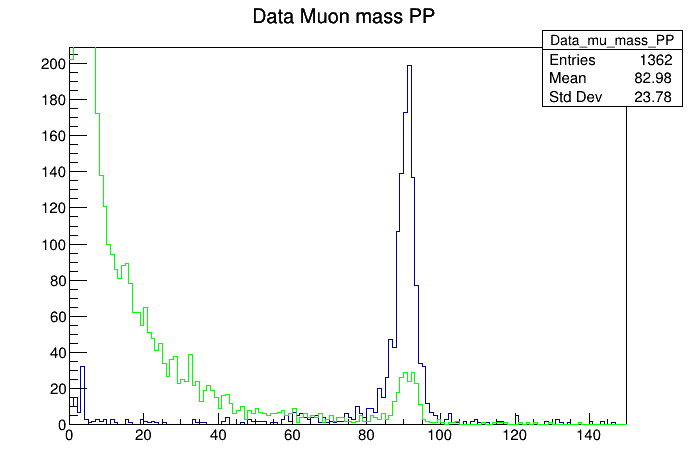

In [3]:
h_passing_probes = ROOT.TH1F("Data_mu_mass_PP","Data Muon mass PP",150,0,150) 
h_failing_probes = ROOT.TH1F("Data_mu_mass_PP","Data Muon mass PP",150,0,150) 
c5=ROOT.TCanvas()

n_pass = 0
n_fail = 0
n_tag = 0

for i in range(tr.GetEntries()):
    tr.GetEntry(i)
    if(tr.muontracks_size>1):
        muons = pt.get_collection(tr, "muontracks")
        for mi in range(len(muons)):
            if(tr.muontracks_chi2[mi]<1.2 and tr.muontracks_chi2[mi]>0.6 and tr.muontracks_dz[mi]<0.003 and tr.muontracks_dB[mi]<0.0015 and tr.muontracks_isoDeposits[mi]<2):
                p4t=muons[mi].p4
                #n_tag = n_tag +1
                for mj in range(len(muons)):
                    if(mj != mi):
                        if(tr.muontracks_chi2[mj]<1.8 and tr.muontracks_chi2[mj]>0.2 and tr.muontracks_dz[mj]<0.005 and tr.muontracks_dB[mj]<0.003 and tr.muontracks_isoDeposits[mj]<4):
                            p4pp=muons[mj].p4
                            s_pass = (p4t+p4pp).M()
                            h_passing_probes.Fill(s_pass)
                            n_pass = n_pass +1
                        else:
                            p4fp=muons[mj].p4
                            s_fail = (p4t+p4fp).M()
                            h_failing_probes.Fill(s_fail)
                            n_fail = n_fail +1
c5.Draw()
h_passing_probes.Draw()
h_failing_probes.SetLineColor(ROOT.kGreen)
h_failing_probes.Draw("SAME")

epsilon = pt.eff(n_pass, n_fail)
#print((n_pass, n_fail, n_tag))
print(epsilon)

 FCN=348.717 FROM MIGRAD    STATUS=CONVERGED     178 CALLS         179 TOTAL
                     EDM=2.76317e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.07306e+01   8.21395e-02   7.23120e-04   6.69750e-03
   2  p1           2.98533e+00   1.11293e-01   9.80158e-04   2.71752e-03
   3  p2           1.19798e+03   3.77458e+01   3.44658e-01   1.31782e-05


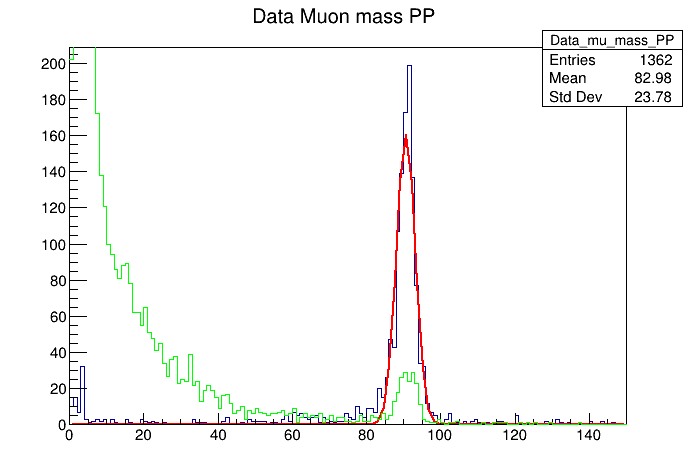

In [4]:
passing=ROOT.TF1("Gauss","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 40,140)
passing.SetParameters(50,10,50)

h_passing_probes.Fit(passing)
c5.Draw()

 FCN=431.694 FROM MIGRAD    STATUS=CONVERGED    1464 CALLS        1465 TOTAL
                     EDM=6.9721e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.08947e+01   2.04247e-01   2.02045e-03   1.21747e-03
   2  p1           2.68055e+00   1.75045e-01   1.69525e-03   4.94186e-04
   3  p2           1.97097e+02   1.63229e+01   1.62867e-01   1.05382e-05
   4  p3           2.16544e+00   4.76129e-01   1.71493e-04   1.09196e-02
   5  p4          -9.34824e-03   2.07272e-03   2.69893e-06   6.56610e-01
   6  p5           2.13956e+01   4.74586e+00   3.06617e-03  -5.25907e-04
   7  p6           7.70877e+03   1.70214e+03   1.23933e+00  -8.14247e-07


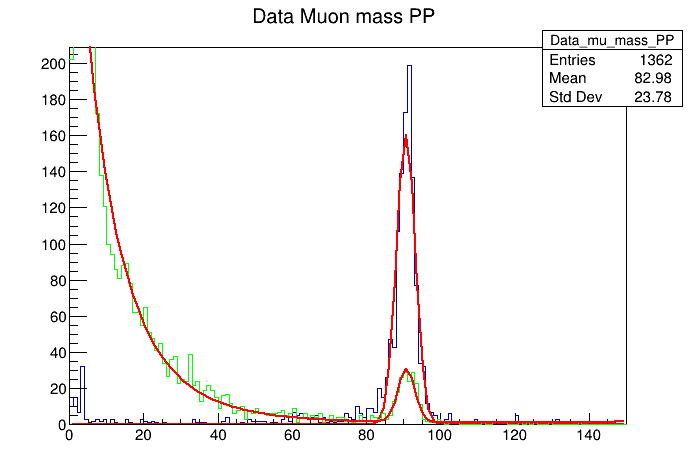

In [10]:
failing=ROOT.TF1("Exp+Gauss","[6]/[5]*TMath::Exp(-(x*[3]+x*x*[4])/[5]) + [2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 40,140)
failing.SetParameters(90,10,10,1,1,500,20)

h_failing_probes.Fit(failing)
c5.Draw()